In [1]:
# Load the dataset
import pandas as pd
df = pd.read_excel('Online Retail.xlsx')

# Step 1: Filter UK transactions
df = df[df['Country'] == 'United Kingdom']

# Step 2: Drop missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Step 3: Remove cancellations and negative values
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  
# If we include cancelled orders Quantity becomes negative, which corrupts TotalPrice = Quantity × UnitPrice skews total revenue/Monetary values
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Step 4: Focus on last 3 months (for freshness)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['InvoiceDate'] >= '2011-09-01']

# Step 5: Optional - Take a balanced sample if still large
df = df.sample(n=20000, random_state=42)

# Step 6: Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [4]:
df.to_csv('updatedfile.csv', index=False)


In [2]:
import datetime as dt

# df is already cleaned and filtered

# Step 1: Reference date (we'll use one day after the last transaction)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Step 2: Group by CustomerID and aggregate
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

# Step 3: Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# Step 4: Sanity check
print(rfm.describe())


           Recency    Frequency      Monetary
count  2375.000000  2375.000000   2375.000000
mean     34.705263     2.055158    158.594426
std      26.708304     2.342941    570.396413
min       1.000000     1.000000      0.550000
25%      11.000000     1.000000     34.345000
50%      28.000000     1.000000     70.980000
75%      54.000000     2.000000    148.790000
max      99.000000    61.000000  17432.960000


In [3]:
# We'll score each column: 1 = lowest, 5 = highest
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine into RFM Score
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

rfm.head() #for first 5 records


,Recency,Frequency,Monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
12747.0,2,2,80.14,5,3,3,533
12748.0,1,61,2347.61,5,5,5,555
12749.0,4,2,152.70,5,3,4,534
12820.0,3,3,89.22,5,4,3,543
12822.0,87,1,46.96,1,1,2,112


In [8]:
def segment_customer(row):
    r = int(row['R'])
    f = int(row['F'])
    m = int(row['M'])

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 4:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'Potential Loyalists'
    elif r >= 3 and f <= 3 and m <= 2:
        return 'At Risk'
    elif r <= 2 and f >= 4:
        return 'Can\'t Lose Them'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Lost'
    elif r <= 2 and f >= 3:
        return 'Hibernating'
    elif r >= 3 and f <= 2:
        return 'Need Attention'
    else:
        return 'Others'
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


C:\Users\Dipanshu Khanna\AppData\Local\Temp\ipykernel_16260\3157550679.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')


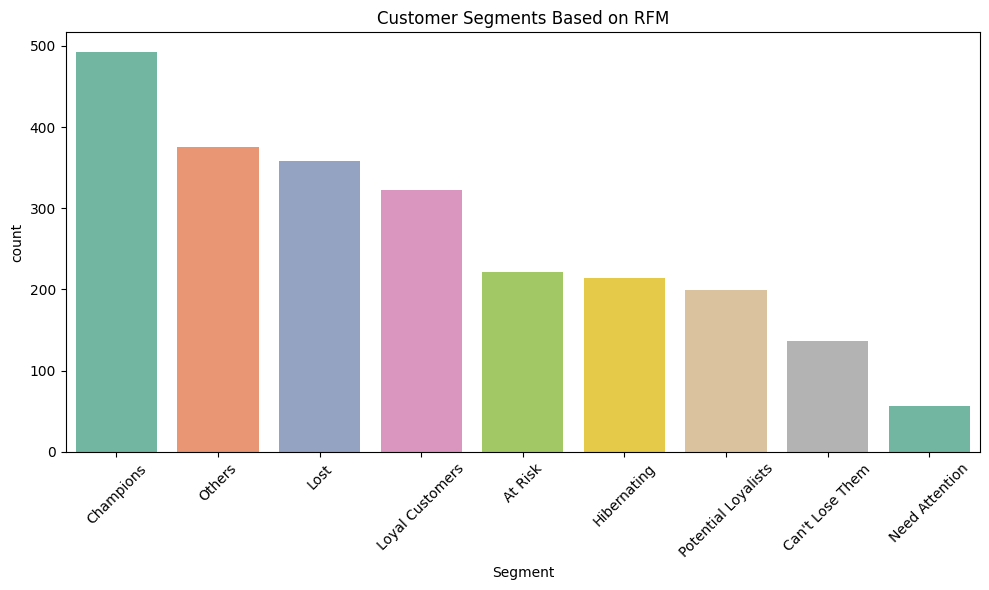

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')
plt.xticks(rotation=45)
plt.title('Customer Segments Based on RFM')
plt.tight_layout()
plt.show()


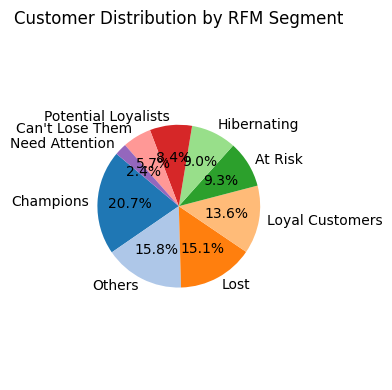

In [11]:
# Count per segment
segment_counts = rfm['Segment'].value_counts()

# Plot pie chart
plt.figure(figsize=(4,4))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('tab20'))
plt.title('Customer Distribution by RFM Segment')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.tight_layout()
plt.show()


| Segment                 | Description                                 | Suggested Strategy                        |
| ----------------------- | ------------------------------------------- | ----------------------------------------- |
| **Champions**           | Recent, frequent, high-spenders             | Exclusive offers, early product launches  |
| **Loyal Customers**     | Frequent buyers                             | Loyalty programs, upsell/cross-sell       |
| **Potential Loyalists** | New but frequent                            | Welcome campaigns, educate on value props |
| **At Risk**             | Haven’t purchased in a while                | Win-back campaigns, feedback surveys      |
| **Can't Lose Them**     | Previously valuable, recently inactive      | Special discounts, personal reach-out     |
| **Hibernating**         | Long-time inactive but once active          | Reactivation emails, new product alerts   |
| **Lost**                | Likely churned                              | Consider removing from campaigns          |
| **Need Attention**      | Moderate frequency/spend, declining recency | Engage with value content or reminders    |
| **Others**              | Don’t fit above clearly                     | Observe or combine with similar segment   |


In [18]:
# Step 1: Label Customers with Actual 6-Month CLTV
#We want to compute, for each customer:
# How much money did they spend in the 6 months after a cutoff date?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


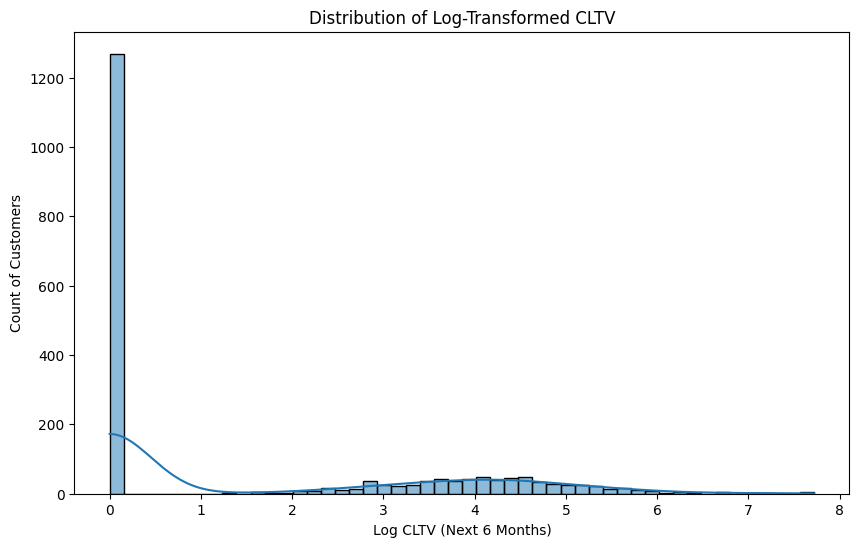

Linear Regression Results:
RMSE: 94.00
R² Score: -0.0746
------------------------------
XGBoost Regressor Results:
RMSE: 92.57
R² Score: -0.0422
------------------------------


,Recency,Customer_Age,Frequency,Monetary,Actual_CLTV,LR_Predicted_CLTV,XGB_Predicted_CLTV
256,53,0,1,62.65,0.0,1.934912,2.401142
352,1,66,6,1129.83,264.9,45.016788,159.158020
298,27,0,1,35.55,0.0,1.894266,1.231896
581,32,0,1,33.00,0.0,1.896636,0.863066
1287,19,0,1,69.97,0.0,1.911608,3.243476


In [34]:
# ------------------------------------------
# Step 1: Set your cutoff date (6 months before last invoice)
# Use your cleaned dataset with 'InvoiceDate', 'InvoiceNo', 'CustomerID', 'TotalPrice' columns
# ------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cutoff_date = pd.to_datetime("2011-11-15")

# Split into pre and post cutoff datasets
df_pre = df[df['InvoiceDate'] <= cutoff_date]
df_post = df[df['InvoiceDate'] > cutoff_date]

# ------------------------------------------
# Step 2: Compute RFM + Customer Age Features (Input Features)
# ------------------------------------------
recency = df_pre.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (cutoff_date - x).days)
age = df_pre.groupby('CustomerID')['InvoiceDate'].agg(lambda x: (x.max() - x.min()).days)
frequency = df_pre.groupby('CustomerID')['InvoiceNo'].nunique()
monetary = df_pre.groupby('CustomerID')['TotalPrice'].sum()

# Combine features into a single DataFrame
features = pd.concat([recency, age, frequency, monetary], axis=1)
features.columns = ['Recency', 'Customer_Age', 'Frequency', 'Monetary']
features = features.reset_index()

# ------------------------------------------
# Step 3: Compute Target Variable (6-Month CLTV)
# ------------------------------------------
target = df_post.groupby('CustomerID')['TotalPrice'].sum().reset_index()
target.columns = ['CustomerID', 'CLTV_6M']

# ------------------------------------------
# Step 4: Merge Features and Target
# ------------------------------------------
cltv_data = pd.merge(features, target, on='CustomerID', how='left')
cltv_data['CLTV_6M'] = cltv_data['CLTV_6M'].fillna(0)

# Apply log transformation to stabilize variance and reduce skewness
cltv_data['CLTV_6M_Log'] = np.log1p(cltv_data['CLTV_6M'])  # log(1 + x)

# ------------------------------------------
# Step 5: Visualize Distribution (Optional)
# ------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(cltv_data['CLTV_6M_Log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed CLTV')
plt.xlabel('Log CLTV (Next 6 Months)')
plt.ylabel('Count of Customers')
plt.show()

# ------------------------------------------
# Step 6: Feature-Target Split
# ------------------------------------------
features_list = ['Recency', 'Customer_Age', 'Frequency', 'Monetary']
target_col = 'CLTV_6M_Log'

X = cltv_data[features_list]
y = cltv_data[target_col]

# ------------------------------------------
# Step 7: Train-Test Split
# ------------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# ------------------------------------------
# Step 8: Train Models (Linear Regression & XGBoost)
# ------------------------------------------
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Initialize models
lr_model = LinearRegression()
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

# Fit models
lr_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# ------------------------------------------
# Step 9: Predict and Inverse Transform
# ------------------------------------------
# Predict on test set
lr_preds_log = lr_model.predict(X_test)
xgb_preds_log = xgb_model.predict(X_test)

# Inverse log transformation to get back to actual CLTV scale
lr_preds = np.expm1(lr_preds_log)
xgb_preds = np.expm1(xgb_preds_log)
y_true = np.expm1(y_test)

# ------------------------------------------
# Step 10: Evaluate the Models
# ------------------------------------------
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 30)

evaluate_model(y_true, lr_preds, "Linear Regression")
evaluate_model(y_true, xgb_preds, "XGBoost Regressor")

# ------------------------------------------
# Step 11: Store Predictions for Analysis
# ------------------------------------------
results_df = X_test.copy()
results_df['Actual_CLTV'] = y_true
results_df['LR_Predicted_CLTV'] = lr_preds
results_df['XGB_Predicted_CLTV'] = xgb_preds

# Show top 5 rows
results_df.head()


In [35]:
cltv_data['WillBuy'] = cltv_data['CLTV_6M'].apply(lambda x: 1 if x > 0 else 0)

# Now build a classifier using same features
X = cltv_data[['Recency', 'Customer_Age', 'Frequency', 'Monetary']]
y = cltv_data['WillBuy']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.69      0.74      0.71       261
           1       0.43      0.37      0.40       139

    accuracy                           0.61       400
   macro avg       0.56      0.55      0.55       400
weighted avg       0.60      0.61      0.60       400



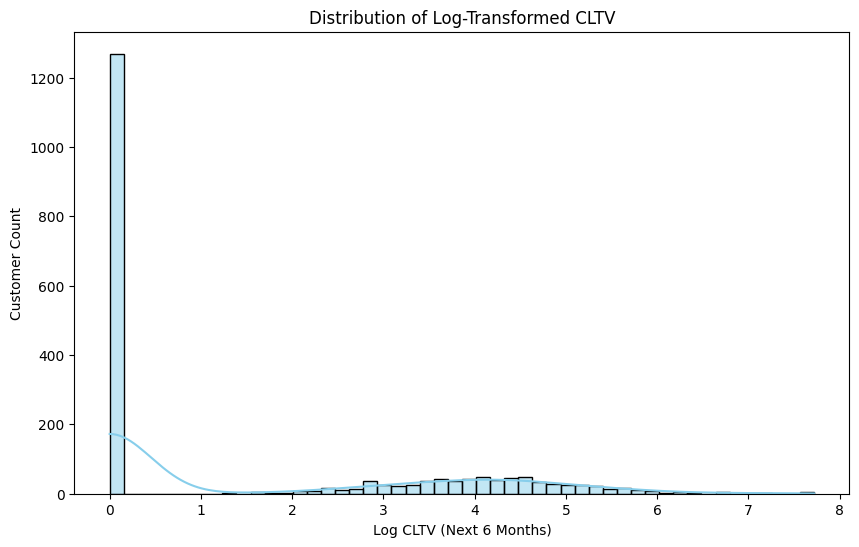

Linear Regression Results:
RMSE: 1.90
R² Score: 0.1222
------------------------------
XGBoost Regressor Results:
RMSE: 2.00
R² Score: 0.0273

Sample Predictions:
      Recency  Customer_Age  Frequency  Monetary  Actual_CLTV  \
256        53             0          1     62.65          0.0   
352         1            66          6   1129.83        264.9   
298        27             0          1     35.55          0.0   
581        32             0          1     33.00          0.0   
1287       19             0          1     69.97          0.0   

      LR_Predicted_CLTV  XGB_Predicted_CLTV  
256            1.934912            2.570098  
352           45.016788          223.694565  
298            1.894266            1.208388  
581            1.896636            1.031067  
1287           1.911608            4.181354  


In [39]:
# Step 0: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Cutoff Date (6 Months Before Last Invoice)
cutoff_date = pd.to_datetime("2011-11-15")  # or df['InvoiceDate'].max() - pd.DateOffset(months=6)

# Step 2: Split Pre/Post Cutoff
df_pre = df[df['InvoiceDate'] <= cutoff_date]
df_post = df[df['InvoiceDate'] > cutoff_date]

# Step 3: Feature Engineering (RFM + Age)
recency = df_pre.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (cutoff_date - x).days)
age = df_pre.groupby('CustomerID')['InvoiceDate'].agg(lambda x: int((x.max() - x.min()) / np.timedelta64(1, 'D')))
frequency = df_pre.groupby('CustomerID')['InvoiceNo'].nunique()
monetary = df_pre.groupby('CustomerID')['TotalPrice'].sum()

features = pd.concat([recency, age, frequency, monetary], axis=1)
features.columns = ['Recency', 'Customer_Age', 'Frequency', 'Monetary']
features = features.reset_index()

# Step 4: Compute Target Variable (CLTV over next 6 months)
target = df_post.groupby('CustomerID')['TotalPrice'].sum().reset_index()
target.columns = ['CustomerID', 'CLTV_6M']

# Step 5: Merge Features + Target, Add log-transform
cltv_data = pd.merge(features, target, on='CustomerID', how='left')
cltv_data['CLTV_6M'] = cltv_data['CLTV_6M'].fillna(0)
cltv_data['CLTV_6M_Log'] = np.log1p(cltv_data['CLTV_6M'])

# Step 6: Visualize Target Distribution
plt.figure(figsize=(10, 6))
sns.histplot(cltv_data['CLTV_6M_Log'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Log-Transformed CLTV')
plt.xlabel('Log CLTV (Next 6 Months)')
plt.ylabel('Customer Count')
plt.show()

# Step 7: Modeling Preparation
X = cltv_data[['Recency', 'Customer_Age', 'Frequency', 'Monetary']]
y = cltv_data['CLTV_6M_Log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression Results:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")
print('-' * 30)

# Step 9: XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost Regressor Results:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

# Step 10: Save Predictions for Evaluation
results_df = X_test.copy()
results_df['Actual_CLTV'] = np.expm1(y_test)  # Reverse log1p
results_df['LR_Predicted_CLTV'] = np.expm1(y_pred_lr)
results_df['XGB_Predicted_CLTV'] = np.expm1(y_pred_xgb)

print("\nSample Predictions:")
print(results_df[['Recency', 'Customer_Age', 'Frequency', 'Monetary', 'Actual_CLTV', 'LR_Predicted_CLTV', 'XGB_Predicted_CLTV']].head())


In [41]:
results_df.to_csv("cltv_predictions.csv", index=False)
